# Lung Cancer Prediction System Using Hybrid CNN-ML Algorithms

This notebook implements a hybrid approach for lung cancer prediction:
1. CNN for feature extraction from lung CT scan images
2. Traditional ML algorithms for classification using the extracted features

## Setup and Dependencies

In [ ]:
# Install required packages
!pip install tensorflow scikit-learn matplotlib pandas numpy seaborn opencv-python

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Upload your own dataset
from google.colab import files
print("Please upload your dataset zip file")
uploaded = files.upload()

# Assuming the uploaded file is a zip file
import zipfile
with zipfile.ZipFile(next(iter(uploaded.keys())), 'r') as zip_ref:
    zip_ref.extractall('lung_cancer_data')

Please upload your dataset zip file


Saving archive.zip to archive.zip


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hamdallak/the-iqothnccd-lung-cancer-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-iqothnccd-lung-cancer-dataset


In [4]:
# Define image size for CNN
IMG_SIZE = 224

def load_and_preprocess_data(data_dir, img_size=IMG_SIZE):
    """Load and preprocess images from directory structure"""
    X = []
    y = []
    class_names = []

    # Find the dataset subdirectory (The IQ-OTHNCCD lung cancer...)
    subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    if not subdirs:
        print(f"No subdirectories found in {data_dir}")
        return np.array(X), np.array(y), class_names

    dataset_dir = os.path.join(data_dir, subdirs[0])
    print(f"Found dataset directory: {dataset_dir}")

    # Define classes based on the actual directory names
    class_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    print(f"Found class directories: {class_dirs}")

    for idx, class_name in enumerate(class_dirs):
        class_names.append(class_name)
        class_dir = os.path.join(dataset_dir, class_name)
        print(f"Processing {class_name} (class {idx})...")

        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Found {len(image_files)} images in {class_name}")

        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            try:
                # Read and preprocess image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read {img_path}")
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, (img_size, img_size))
                img = img / 255.0  # Normalize to [0,1]

                X.append(img)
                y.append(idx)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    return np.array(X), np.array(y), class_names

# Load and preprocess data
try:
    X, y, class_names = load_and_preprocess_data('lung_cancer_data')
    if len(X) > 0:
        print(f"Loaded {len(X)} images with shape {X.shape}")
        print(f"Class distribution: {np.bincount(y)}")
        print(f"Classes: {class_names}")

        # Number of classes
        num_classes = len(class_names)
        print(f"Number of classes: {num_classes}")
    else:
        print("No images were loaded. Please check the dataset structure.")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please check your dataset structure and adjust the code accordingly.")

Found dataset directory: lung_cancer_data/The IQ-OTHNCCD lung cancer dataset
Found class directories: ['Bengin cases', 'Malignant cases', 'Normal cases']
Processing Bengin cases (class 0)...
Found 120 images in Bengin cases
Processing Malignant cases (class 1)...
Found 561 images in Malignant cases
Processing Normal cases (class 2)...
Found 416 images in Normal cases
Loaded 1097 images with shape (1097, 224, 224, 3)
Class distribution: [120 561 416]
Classes: ['Bengin cases', 'Malignant cases', 'Normal cases']
Number of classes: 3


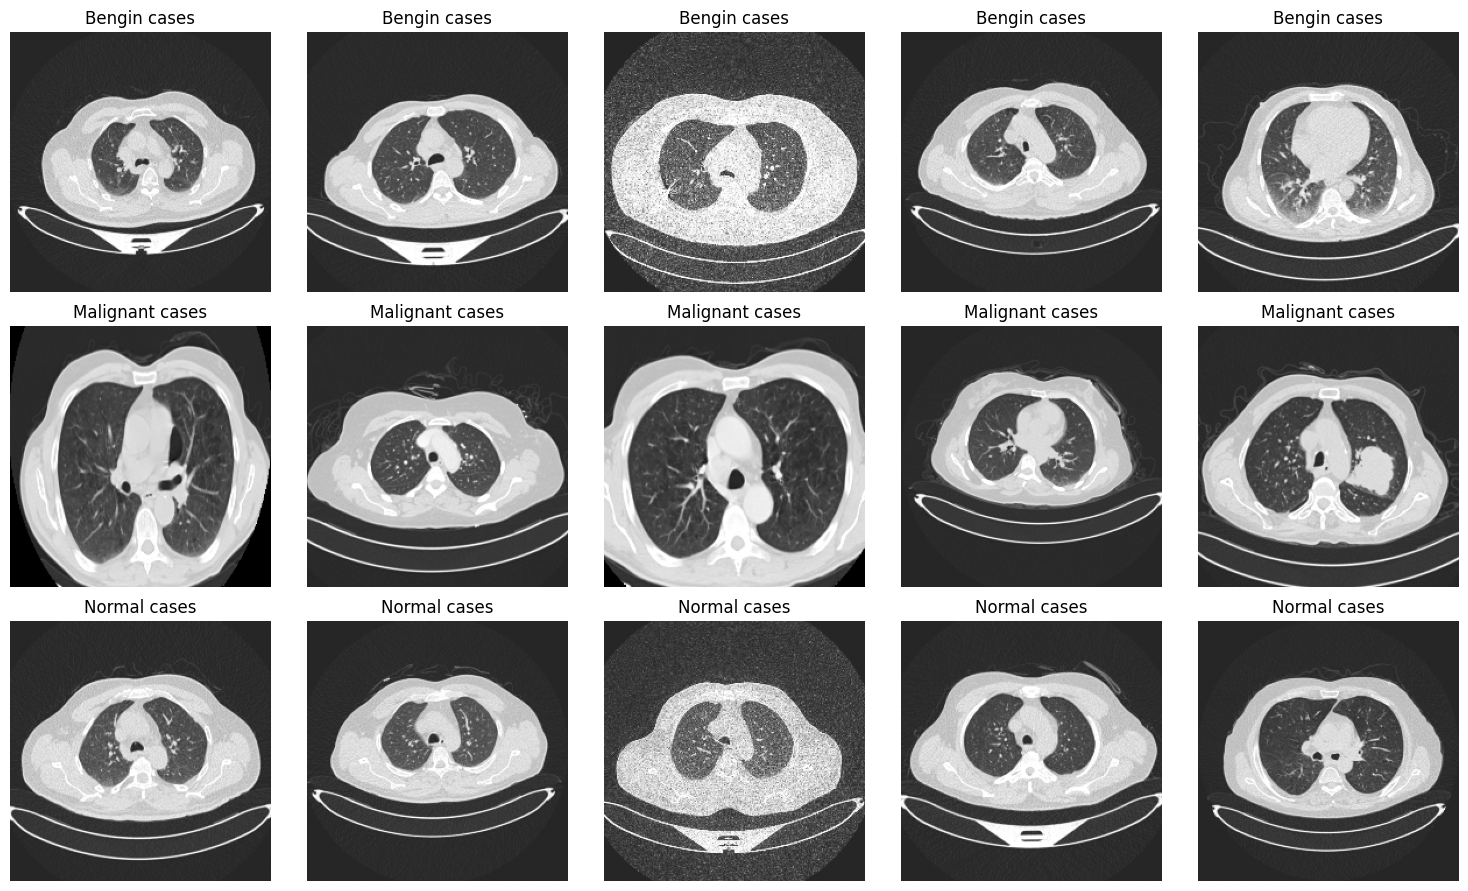

In [5]:
# Visualize some sample images
def visualize_samples(X, y, class_names, n_samples=5):
    """Visualize sample images from each class"""
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, n_samples, figsize=(15, 3*num_classes))

    for class_idx in range(num_classes):
        class_samples = X[y == class_idx]
        for i in range(min(n_samples, len(class_samples))):
            if num_classes > 1:
                ax = axes[class_idx, i]
            else:
                ax = axes[i]
            ax.imshow(class_samples[i])
            ax.set_title(f"{class_names[class_idx]}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

try:
    visualize_samples(X, y, class_names)
except Exception as e:
    print(f"Error visualizing samples: {e}")

In [6]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Convert labels to categorical for multi-class classification
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

Training set: (767, 224, 224, 3), (767,)
Validation set: (165, 224, 224, 3), (165,)
Test set: (165, 224, 224, 3), (165,)


## CNN Feature Extraction Model

We'll use transfer learning with pre-trained models for feature extraction.

In [7]:
def build_feature_extractor(base_model='vgg16', num_classes=3):
    """Build a CNN feature extractor using transfer learning"""
    if base_model == 'vgg16':
        base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    elif base_model == 'resnet50':
        base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    else:
        raise ValueError(f"Unsupported base model: {base_model}")

    # Freeze the base model layers
    for layer in base.layers:
        layer.trainable = False

    # Add custom layers on top
    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')  # Changed to softmax for multi-class
    ])

    return model

# Build and compile the CNN model
cnn_model = build_feature_extractor('vgg16', num_classes=num_classes)
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Changed to categorical_crossentropy for multi-class
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

cnn_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,880,835 (56.77 MB)

 Trainable params: 165,379 (646.01 KB)

 Non-trainable params: 14,715,456 (56.14 MB)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ✅ 1. Lighter & faster augmentation
datagen = ImageDataGenerator(
    rotation_range=5,               # Reduced to speed up preprocessing
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ✅ 2. Efficient callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),  # faster early stopping
    ModelCheckpoint('best_cnn_model_fast.h5', monitor='val_accuracy', save_best_only=True, mode='max')
]

# ✅ 3. Train the model with larger batch size (improves GPU usage)
history = cnn_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=128),
    validation_data=(X_val, y_val_cat),
    epochs=15,
    callbacks=callbacks,
    verbose=2  # reduces console overhead (optional)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


6/6 - 88s - 15s/step - accuracy: 0.2907 - auc: 0.4513 - loss: 1.9978 - precision: 0.2748 - recall: 0.2347 - val_accuracy: 0.4667 - val_auc: 0.6418 - val_loss: 1.0285 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15


6/6 - 11s - 2s/step - accuracy: 0.3559 - auc: 0.5264 - loss: 1.7166 - precision: 0.3599 - recall: 0.3116 - val_accuracy: 0.5152 - val_auc: 0.7013 - val_loss: 1.0134 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
6/6 - 11s - 2s/step - accuracy: 0.4120 - auc: 0.5775 - loss: 1.5686 - precision: 0.4126 - recall: 0.3507 - val_accuracy: 0.5091 - val_auc: 0.7340 - val_loss: 0.9995 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
6/6 - 11s - 2s/step - accuracy: 0.4289 - auc: 0.6194 - loss: 1.4046 - precision: 0.4401 - recall: 0.3833 - val_accuracy: 0.5030 - val_auc: 0.7581 - val_loss: 0.9846 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
6/6 - 10s - 2s/step - accuracy: 0.5293 - auc: 0.7037 - loss: 1.1867 - precision: 0.5419 - recall: 0.4641 - val_accuracy: 0.5030 - val_auc: 0.7741 - val_loss: 0.9716 - val_precision: 1.0000 - val_recall: 0.0182
Epoch 6/15
6/6 - 10s - 2s/step - accuracy: 0.5398 - auc: 0.7160 - loss: 1.2004 - precision: 0.5710 - re

6/6 - 11s - 2s/step - accuracy: 0.6688 - auc: 0.8521 - loss: 0.7691 - precision: 0.6980 - recall: 0.6389 - val_accuracy: 0.5212 - val_auc: 0.8234 - val_loss: 0.8629 - val_precision: 0.8300 - val_recall: 0.5030


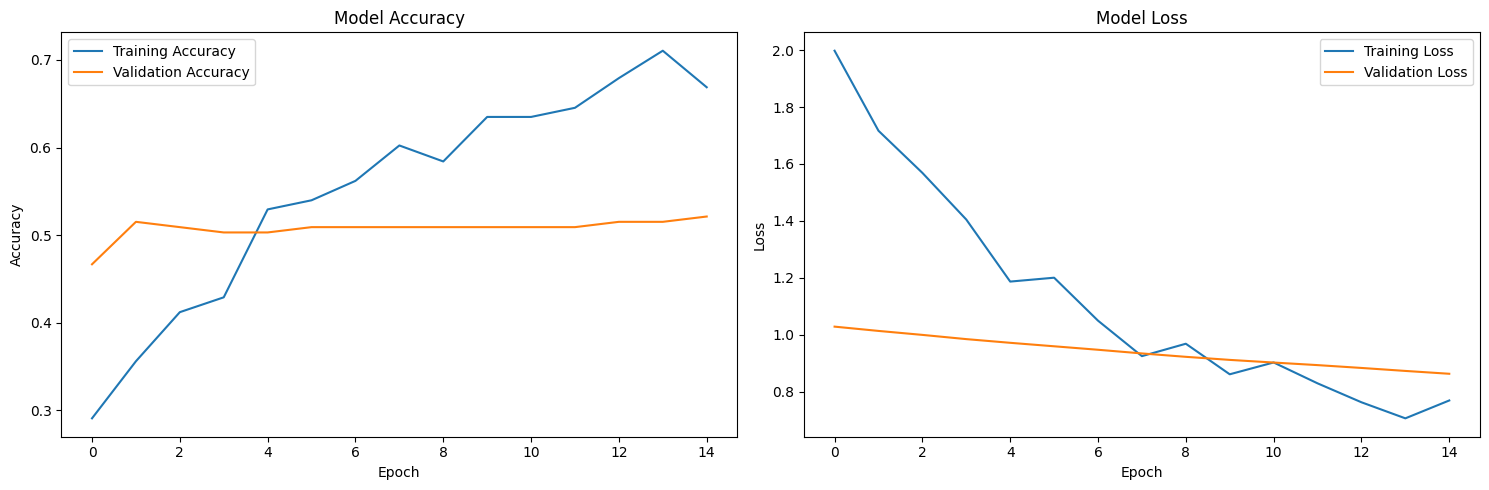

In [9]:
# Visualize training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Feature Extraction for ML Models

Now we'll extract features from the CNN model to use with traditional ML algorithms.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Load model
model = load_model('/content/best_cnn_model_fast.h5')

# Pass dummy input to call the model and avoid "never been called" errors
_ = model.predict(np.expand_dims(X_train[0], axis=0))

# Extract output from a specific layer directly
feature_layer_name = 'dropout_1'
feature_layer = model.get_layer(feature_layer_name)

# Create a functional model with actual inputs
input_tensor = tf.keras.Input(shape=X_train.shape[1:])  # e.g., (224, 224, 3)
x = input_tensor
for layer in model.layers:
    x = layer(x)
    if layer.name == feature_layer_name:
        break

feature_extractor = tf.keras.Model(inputs=input_tensor, outputs=x)

# Extract features
X_train_features = feature_extractor.predict(X_train)
X_val_features = feature_extractor.predict(X_val)
X_test_features = feature_extractor.predict(X_test)

print(f"Extracted features shape: {X_train_features.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 571ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Extracted features shape: (767, 128)


## Machine Learning Models

Now we'll train various ML models using the extracted features.

In [11]:
# Define ML models to try
ml_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate each model
results = {}
best_model = None
best_score = 0

for name, model in ml_models.items():
    print(f"\nTraining {name}...")

    # Create a pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train_features, y_train)

    # Evaluate on validation set
    y_val_pred = pipeline.predict(X_val_features)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")

    # Save results
    results[name] = {
        'model': pipeline,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    }

    # Track best model
    if val_f1 > best_score:
        best_score = val_f1
        best_model = name


Training Random Forest...
Validation Accuracy: 0.9030
Validation Precision: 0.9035
Validation Recall: 0.9030
Validation F1 Score: 0.8918

Training SVM...
Validation Accuracy: 0.8909
Validation Precision: 0.8912
Validation Recall: 0.8909
Validation F1 Score: 0.8769

Training Gradient Boosting...
Validation Accuracy: 0.9030
Validation Precision: 0.9130
Validation Recall: 0.9030
Validation F1 Score: 0.8945

Training KNN...
Validation Accuracy: 0.9030
Validation Precision: 0.8986
Validation Recall: 0.9030
Validation F1 Score: 0.8946


<Figure size 1200x800 with 0 Axes>

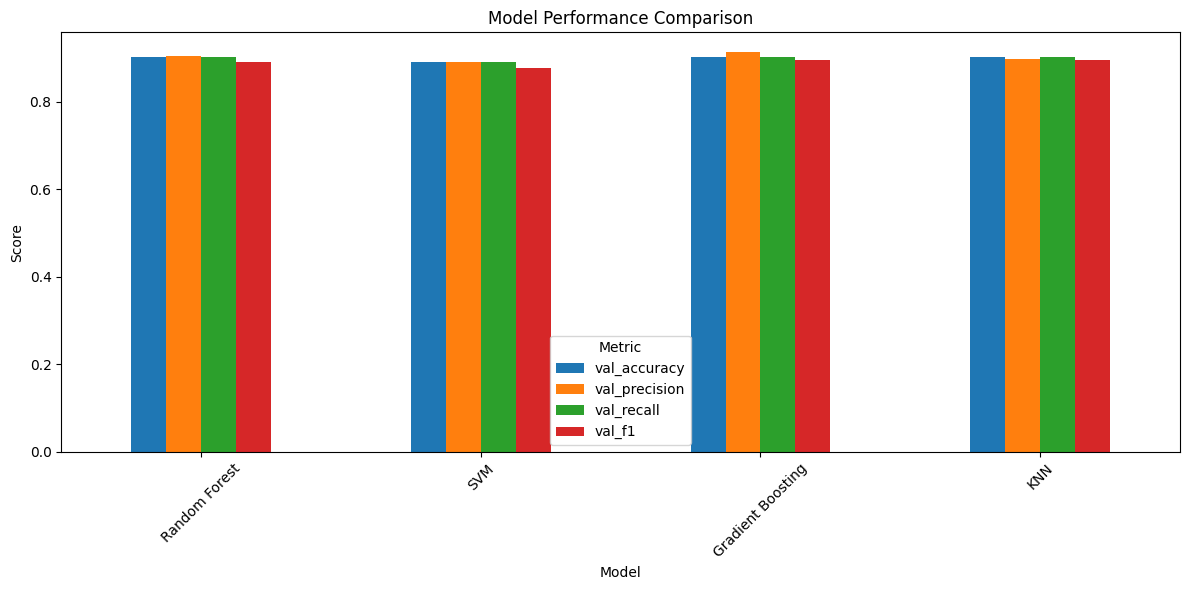

Best model: KNN with F1 Score: 0.8946


In [12]:
# Compare model performances
metrics = ['val_accuracy', 'val_precision', 'val_recall', 'val_f1']
model_names = list(results.keys())
comparison_df = pd.DataFrame(index=model_names, columns=metrics)

for name in model_names:
    for metric in metrics:
        comparison_df.loc[name, metric] = results[name][metric]

# Plot comparison
plt.figure(figsize=(12, 8))
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

print(f"Best model: {best_model} with F1 Score: {best_score:.4f}")

## Evaluate Best Model on Test Set


Test Results for KNN:
Accuracy: 0.9212
Precision: 0.9180
Recall: 0.9212
F1 Score: 0.9147


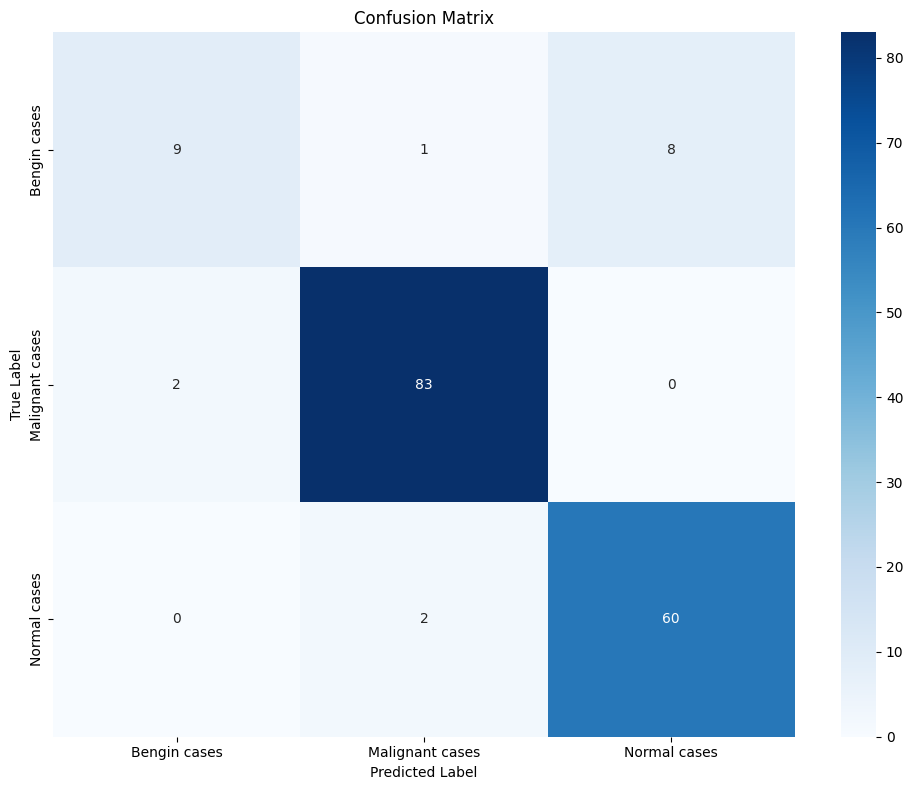


Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       0.82      0.50      0.62        18
Malignant cases       0.97      0.98      0.97        85
   Normal cases       0.88      0.97      0.92        62

       accuracy                           0.92       165
      macro avg       0.89      0.81      0.84       165
   weighted avg       0.92      0.92      0.91       165



In [13]:
# Get the best model
best_pipeline = results[best_model]['model']

# Evaluate on test set
y_test_pred = best_pipeline.predict(X_test_features)
y_test_prob = best_pipeline.predict_proba(X_test_features)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"\nTest Results for {best_model}:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

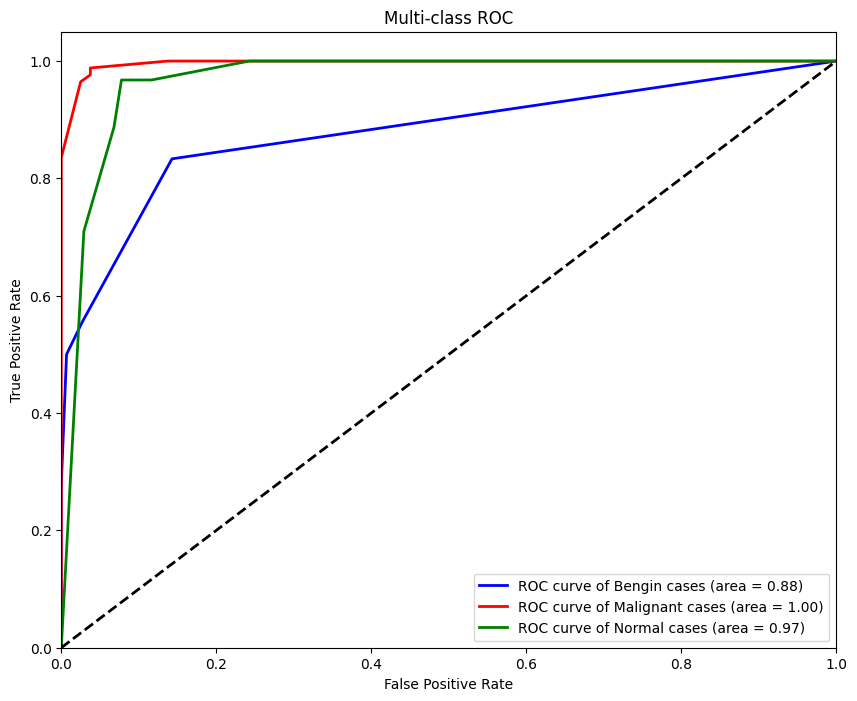

In [14]:
# ROC Curve for multi-class (one-vs-rest)
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output for ROC curve
y_test_bin = label_binarize(y_test, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

## Hyperparameter Tuning (Optional)

We can further improve the best model with hyperparameter tuning.

Tuning hyperparameters for KNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
Best cross-validation score: 0.9340

Tuned Model Test Results:
Accuracy: 0.9333
Precision: 0.9314
Recall: 0.9333
F1 Score: 0.9299

Model Comparison:
           Original Model  Tuned Model
Accuracy         0.921212     0.933333
Precision        0.917988     0.931383
Recall           0.921212     0.933333
F1 Score         0.914653     0.929935


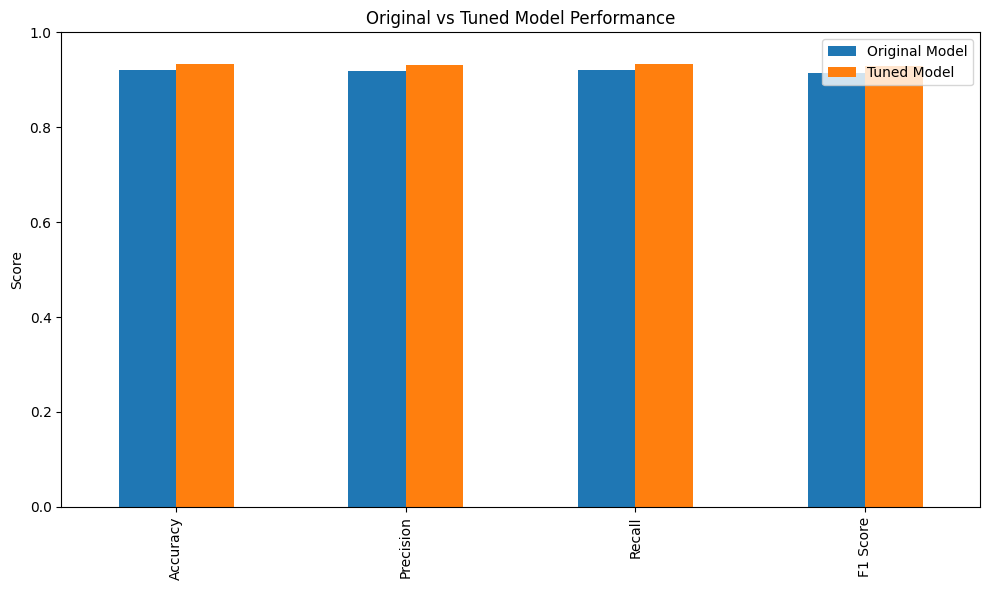

In [15]:
# Define hyperparameter grids for each model type
param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto', 0.1, 0.01],
        'classifier__kernel': ['rbf', 'linear']
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    }
}

# Tune the best model
print(f"Tuning hyperparameters for {best_model}...")
param_grid = param_grids[best_model]
grid_search = GridSearchCV(
    results[best_model]['model'],
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_features, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate tuned model on test set
tuned_model = grid_search.best_estimator_
y_test_pred_tuned = tuned_model.predict(X_test_features)
y_test_prob_tuned = tuned_model.predict_proba(X_test_features)

# Calculate metrics for tuned model
test_accuracy_tuned = accuracy_score(y_test, y_test_pred_tuned)
test_precision_tuned = precision_score(y_test, y_test_pred_tuned, average='weighted')
test_recall_tuned = recall_score(y_test, y_test_pred_tuned, average='weighted')
test_f1_tuned = f1_score(y_test, y_test_pred_tuned, average='weighted')

print(f"\nTuned Model Test Results:")
print(f"Accuracy: {test_accuracy_tuned:.4f}")
print(f"Precision: {test_precision_tuned:.4f}")
print(f"Recall: {test_recall_tuned:.4f}")
print(f"F1 Score: {test_f1_tuned:.4f}")

# Compare original vs tuned model
comparison = pd.DataFrame({
    'Original Model': [test_accuracy, test_precision, test_recall, test_f1],
    'Tuned Model': [test_accuracy_tuned, test_precision_tuned, test_recall_tuned, test_f1_tuned]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

print("\nModel Comparison:")
print(comparison)

# Plot comparison
comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Original vs Tuned Model Performance')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

## Save Models for Future Use

In [17]:
import pickle

# Save the CNN feature extractor
feature_extractor.save('lung_cancer_feature_extractor.h5')

# Save the best ML model
with open('lung_cancer_ml_model.pkl', 'wb') as f:
    pickle.dump(tuned_model, f)

# Save class names for future reference
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

print("Models saved successfully!")

Models saved successfully!


## Create Prediction Function for New Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


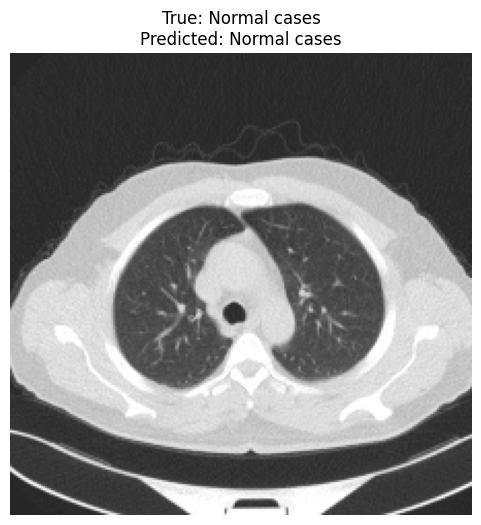

Prediction: Normal cases
True label: Normal cases

Class probabilities:
Bengin cases: 0.0000
Malignant cases: 0.0000
Normal cases: 1.0000


In [18]:
def predict_lung_cancer(image_path, feature_extractor, ml_model, class_names, img_size=IMG_SIZE):
    """Predict lung cancer from a CT scan image"""
    # Read and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        return "Error: Could not read image"

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Extract features
    features = feature_extractor.predict(img)

    # Predict using ML model
    prediction = ml_model.predict(features)[0]
    probabilities = ml_model.predict_proba(features)[0]

    result = {
        'prediction': class_names[prediction],
        'class_index': int(prediction),
        'probabilities': {class_names[i]: float(prob) for i, prob in enumerate(probabilities)}
    }

    return result

# Test the prediction function on a sample image
try:
    # Get a sample image from the test set
    sample_idx = np.random.randint(0, len(X_test))
    sample_img = X_test[sample_idx]
    sample_label = class_names[y_test[sample_idx]]

    # Save the sample image temporarily
    sample_path = 'sample_test_image.jpg'
    cv2.imwrite(sample_path, cv2.cvtColor((sample_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

    # Make prediction
    result = predict_lung_cancer(sample_path, feature_extractor, tuned_model, class_names)

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(sample_img)
    plt.title(f"True: {sample_label}\nPredicted: {result['prediction']}")
    plt.axis('off')
    plt.show()

    print(f"Prediction: {result['prediction']}")
    print(f"True label: {sample_label}")
    print("\nClass probabilities:")
    for class_name, prob in result['probabilities'].items():
        print(f"{class_name}: {prob:.4f}")
except Exception as e:
    print(f"Error testing prediction function: {e}")

## Test with Your Own Images

You can upload your own CT scan images to test the model.

Please upload a lung CT scan image


Saving Malignant case (92).jpg to Malignant case (92).jpg

Predicting for Malignant case (92).jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


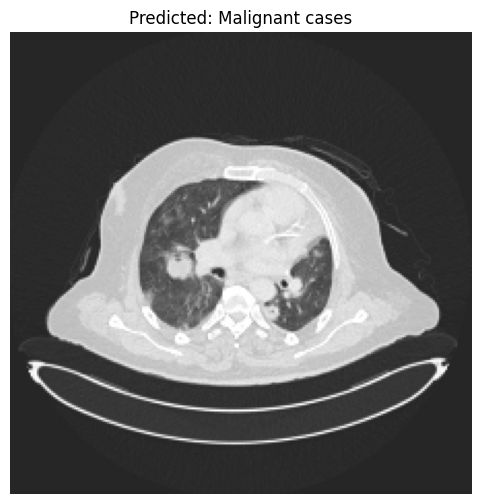

Prediction: Malignant cases

Class probabilities:
Bengin cases: 0.0000
Malignant cases: 1.0000
Normal cases: 0.0000


In [19]:
from google.colab import files

def test_with_uploaded_image():
    print("Please upload a lung CT scan image")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nPredicting for {filename}...")
        result = predict_lung_cancer(filename, feature_extractor, tuned_model, class_names)

        # Display image and prediction
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Predicted: {result['prediction']}")
        plt.axis('off')
        plt.show()

        print(f"Prediction: {result['prediction']}")
        print("\nClass probabilities:")
        for class_name, prob in result['probabilities'].items():
            print(f"{class_name}: {prob:.4f}")

# Uncomment to test with your own images
test_with_uploaded_image()

## Conclusion

In this notebook, we've built a hybrid CNN-ML system for lung cancer prediction from CT scan images. The system consists of:

1. A CNN feature extractor based on transfer learning
2. Traditional ML classifiers that use the extracted features
3. Hyperparameter tuning to optimize performance
4. A prediction function for new images

The hybrid approach combines the feature extraction power of CNNs with the interpretability and efficiency of traditional ML algorithms. Our model can classify lung CT scans into three categories:
- Benign cases
- Malignant cases
- Normal cases

### Next Steps

To further improve the system, you could:

1. Collect more training data
2. Try different CNN architectures (e.g., DenseNet, EfficientNet)
3. Implement explainability techniques like Grad-CAM to visualize important regions
4. Explore ensemble methods combining multiple models
5. Implement cross-validation for more robust evaluation

Remember that this is a demonstration system and should not be used for actual medical diagnosis without proper clinical validation.